In [24]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
import logging
import optuna
import shap

from itertools import combinations
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    roc_auc_score,
    accuracy_score, 
    precision_score, 
    recall_score, 
    make_scorer,
    f1_score
)

warnings.filterwarnings("ignore", category=RuntimeWarning)
optuna.logging.set_verbosity(logging.WARNING)

### Первичный анализ данных

In [7]:
# Загружаем данные
path = r'..\notebooks\DATA\Telco-Customer-Churn.csv'
data = pd.read_csv(path)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [9]:
# Выделяем списки названий столбцов категориальных и числовых данных
num_cols = data.select_dtypes(include=['float', 'int']).columns.to_list()
cat_cols = data.select_dtypes(exclude=['float', 'int']).columns.to_list()
target_col = 'Churn'

In [10]:
# Смотрим на количественные данные, видим, что SeniorCitizen - категориальный, нужно это учесть
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


In [11]:
# Изменяем тип данных для признака SeniorCitizen
data['SeniorCitizen'] = data['SeniorCitizen'].astype('str')

# Создаем списки названий признаков еще раз
num_cols = data.select_dtypes(include=['float', 'int']).columns.to_list()
cat_cols = data.select_dtypes(exclude=['float', 'int']).columns.to_list()

In [12]:
# Смотрим на описательную статистику по категориальным признакам и вычисляем долю самых частых ответов
data[cat_cols].describe().T.assign(share=lambda x: round(x['freq']/x['count'],2))

,count,unique,top,freq,share
customerID,7032,7032,7590-VHVEG,1,0.000142
gender,7032,2,Male,3549,0.504693
SeniorCitizen,7032,2,0,5890,0.8376
Partner,7032,2,No,3639,0.517491
Dependents,7032,2,No,4933,0.701507
PhoneService,7032,2,Yes,6352,0.903299
MultipleLines,7032,3,No,3385,0.481371
InternetService,7032,3,Fiber optic,3096,0.440273
OnlineSecurity,7032,3,No,3497,0.497298
OnlineBackup,7032,3,No,3087,0.438993


#### Анализ числовых данных

Pairplots: распределения числовых переменных и перекрестные scatterplots:  
Можно заметить, что MonthlyCharges равномерно распределени для всего диапазона tenure;  
Распределения числовых переменных имеют сильные перекосы. В случае tenure, MonthlyCharges - бимодальные.
С ростом tenure окно значений TotalCharges увеличивается, что может зависеть от количества дополнительных услуг, которые пользователи при одинаковых tenure закупают от оператора

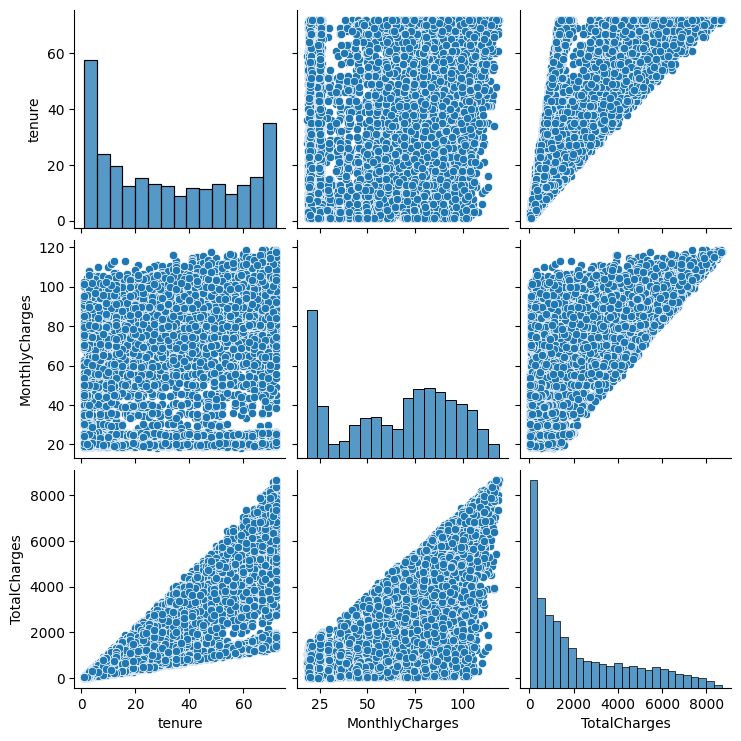

In [13]:
sns.pairplot(data[num_cols], kind='scatter', diag_kind='hist')

Построим наложенные друг на друга гистограммы признаков отфильтрованных по таргету

In [14]:
def create_histograms_for_numeric_columns(data, numeric_columns):
    for col in numeric_columns:
        plt.subplots(figsize=(7,3))
        plt.hist(x=data[data[target_col] == 'No'][col], bins = 70, label=f'{col}, churn: No', alpha=0.7)
        plt.hist(x=data[data[target_col] == 'Yes'][col], bins = 70, label=f'{col}, churn: Yes', alpha=0.7)
        plt.legend()
        plt.show()

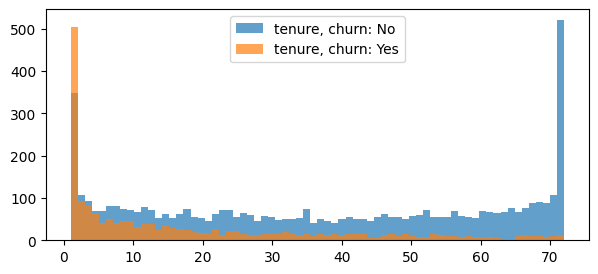

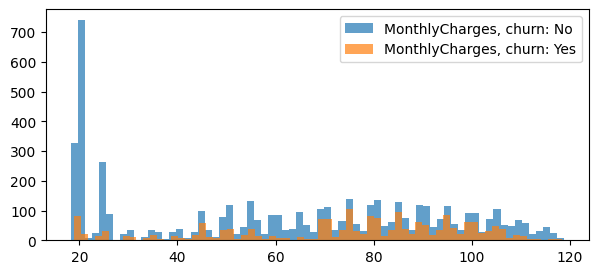

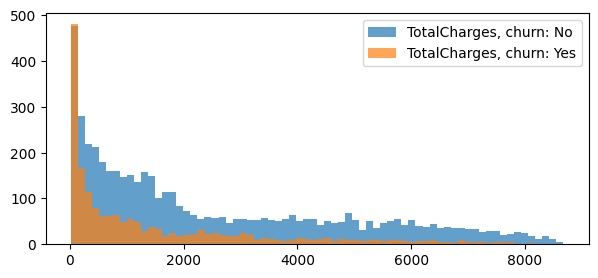

In [15]:
create_histograms_for_numeric_columns(data, num_cols)

Видим, что Churn самый высокий для небольших tenure (то есть, если пользователь уходит, то вначале);  
Со временем, показатель снижается до небольших значений. Визуально, чем больше tenure, тем более пльзователь лоялен;  
Наибольшая доля утекающих пользователей в диапазоне от 70 до 110 по MonthlyCharges

Проверим корреляционную матрицу

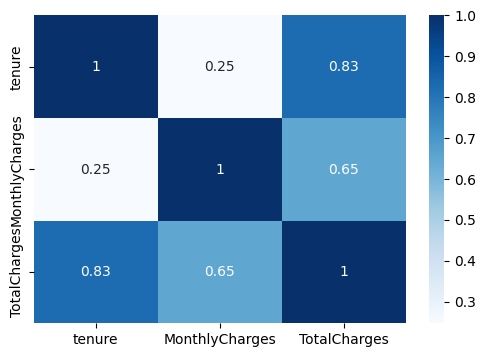

In [16]:
plt.figure(figsize=(6,4))
sns.heatmap(data[num_cols].corr(method='pearson'), cmap='Blues', annot=True)
plt.show()

Ожидаемо, Tenure <> TotalCharges сильно скоррелированы (> 0.83), MonthlyCharges <> Total Charges - допустимо (< 0.7)

Violinplots: как правило, очень информативны в плане распределения

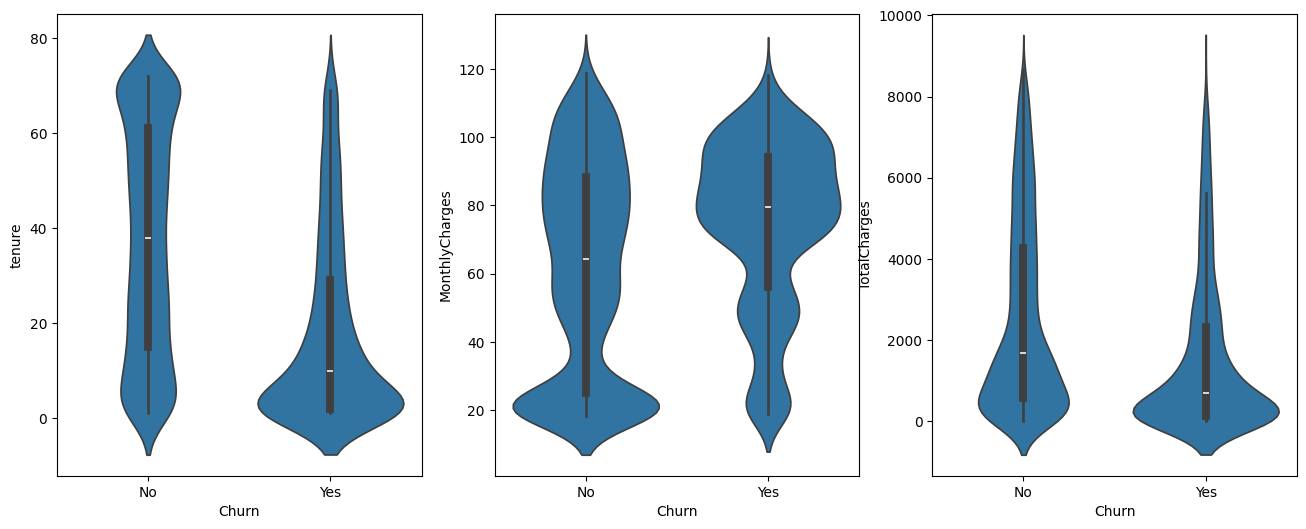

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(16,6))
ax = ax.flatten()
for ix, numeric_col in enumerate(num_cols):
    sns.violinplot(data=data, x=target_col, y=numeric_col, ax=ax[ix])
plt.show()

#### Анализ категориальных данных

In [18]:
data[cat_cols].describe().T

,count,unique,top,freq
customerID,7032,7032,7590-VHVEG,1
gender,7032,2,Male,3549
SeniorCitizen,7032,2,0,5890
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087


Barplots groupby categorical, target: сможем увидеть информацию по тому, для каких категорий churn выше всего

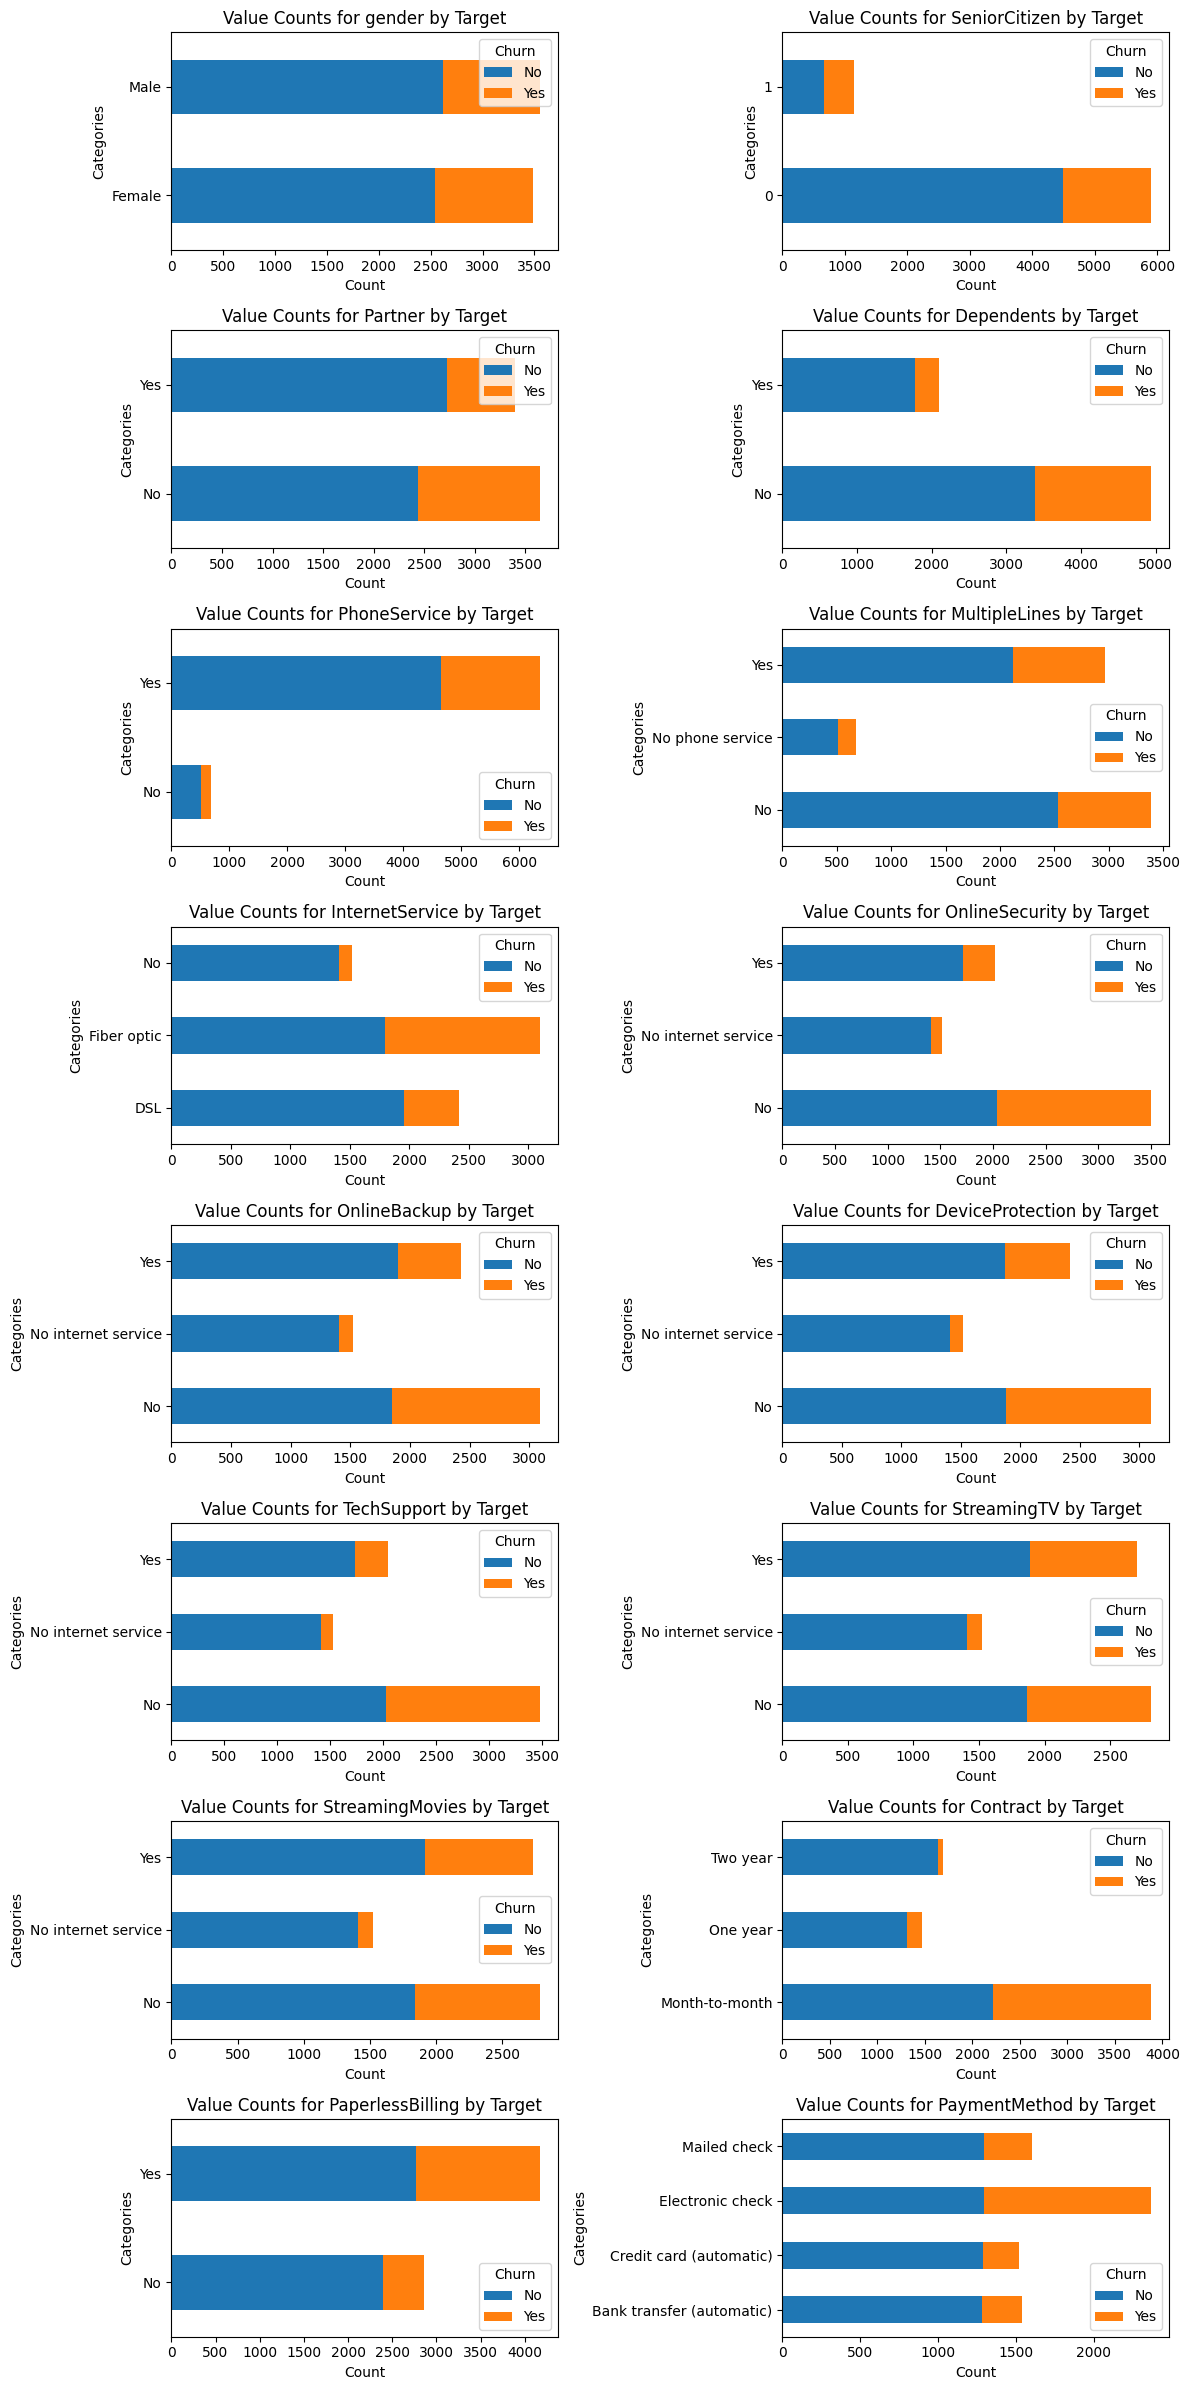

In [19]:
cat_cols_subset = cat_cols[1:-1]

n_plots = len(cat_cols_subset)
nrows = n_plots // 2 + n_plots % 2 
ncols = 2 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
ax = ax.flatten()

for i, col in enumerate(cat_cols_subset):
    grouped = data.groupby([col, target_col]).size().unstack(fill_value=0)
    
    grouped.plot.barh(stacked=True, ax=ax[i])
    ax[i].set_title(f'Value Counts for {col} by Target')
    ax[i].set_xlabel('Count')
    ax[i].set_ylabel('Categories')

for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()


Заметки по граифкам (визуальные, не строгие):  
- Gender: схожее процентное соотношение churn по полам
- SeniorCitizen: на первый взгляд, процентное соотношение схожее, возможно seniorCitizen немного чаще уходят  
- Partner: No Partner уходят чаще  
- Dependants: No Dependants уходят чаще
- Phone Service: Визуально пропорция одинаковая (очевидно, что phone service - основная услуга для клиентов)
- Multiple Lines: примерно похожи  
- Internet Service: сильно чаще уходят:  
-- пользователи FiberOptic, без Online Security, без Online Backup, без DeviceProtection, и без Tech Support  
- StreamingTV, StreamingMovies: схожее соотношение chunk  
- Contract, PaperlessBilling, PaymentMethod:  
-- чаще уходят те, кому это интуитивно легче сделать: на помесячных контрактах, с paperlessbilling, с electronic check.

Хочу увидеть количество chunk = 'Yes' в процентном соотношении от всех chunk для каждой категории

In [20]:
def create_summary_table(data, cat_cols_subset, target_col):
    """
    Создает сводную таблицу для анализа категориальных признаков относительно целевого столбца.
    
    Параметры:
    - data: DataFrame, исходные данные.
    - cat_cols_subset: список категориальных признаков, которые нужно проанализировать.
    - target_col: имя целевого столбца (например, "Yes"/"No").
    
    Возвращает:
    - summary_table: сводная таблица с агрегированными данными и процентными соотношениями.
    """
    # Создаем копию данных, чтобы не изменять исходный DataFrame
    df = data.copy()
    summary_table = []  # Список для хранения результатов для каждого категориального признака

    # Перебираем каждый категориальный признак из подмножества
    for channel in cat_cols_subset:
        # Переименовываем текущий категориальный признак в 'Sub_Categories' для удобства группировки
        grouped = (
            df.rename(columns={channel: 'Sub_Categories'})
            .groupby(['Sub_Categories', target_col])  # Группируем по категориям и целевому столбцу
            .size()  # Подсчитываем количество записей в каждой группе
            .unstack(fill_value=0)  # Преобразуем данные в сводную таблицу (столбцы = значения целевого столбца)
        )
        
        # Добавляем столбец 'Total', содержащий суммарное количество записей для каждой категории
        grouped['Total'] = grouped.sum(axis=1)

        # Вычисляем процентное соотношение для каждого значения целевого столбца
        grouped_percent = round(grouped.div(grouped['Total'], axis=0) * 100, 2)  # Делим на сумму и умножаем на 100
        grouped_percent = grouped_percent.add_suffix(' (%)')  # Добавляем суффикс ' (%)' к названиям столбцов

        # Объединяем абсолютные значения и проценты в одну таблицу
        result = pd.concat([grouped, grouped_percent], axis=1)

        # Возвращаем индекс ('Sub_Categories') обратно в виде столбца
        result = result.reset_index()

        # Добавляем столбец 'Channel_Type', указывающий, какой категориальный признак анализируется
        result.insert(0, 'Channel_Type', channel)

        # Добавляем результат для текущего признака в общий список
        summary_table.append(result)

    # Объединяем все результаты в одну сводную таблицу
    summary_table = pd.concat(summary_table, ignore_index=True)

    # Добавляем столбец 'Yes_to_total_yes (%)', который показывает долю значений 'Yes'
    # относительно общего количества 'Yes' по всем категориям
    summary_table['Yes_to_total_yes (%)'] = round(
        summary_table['Yes'] / summary_table['Yes'].sum(axis=0) * 100, 2
    )

    # Сортируем таблицу по столбцу 'Yes_to_total_yes (%)' в порядке убывания
    summary_table.sort_values(by='Yes_to_total_yes (%)', ascending=False, inplace=True)

    # Сбрасываем индекс после сортировки
    summary_table.reset_index(drop=True, inplace=True)

    # Удаляем имя столбца (если оно было установлено ранее)
    summary_table.columns.name = None

    return summary_table

In [21]:
create_summary_table(data=data, cat_cols_subset=cat_cols_subset, target_col=target_col)

,Channel_Type,Sub_Categories,No,Yes,Total,No (%),Yes (%),Total (%),Yes_to_total_yes (%)
0,PhoneService,Yes,4653,1699,6352,73.25,26.75,100.0,5.68
1,Contract,Month-to-month,2220,1655,3875,57.29,42.71,100.0,5.53
2,Dependents,No,3390,1543,4933,68.72,31.28,100.0,5.16
3,OnlineSecurity,No,2036,1461,3497,58.22,41.78,100.0,4.89
4,TechSupport,No,2026,1446,3472,58.35,41.65,100.0,4.84
5,PaperlessBilling,Yes,2768,1400,4168,66.41,33.59,100.0,4.68
6,SeniorCitizen,0,4497,1393,5890,76.35,23.65,100.0,4.66
7,InternetService,Fiber optic,1799,1297,3096,58.11,41.89,100.0,4.34
8,OnlineBackup,No,1854,1233,3087,60.06,39.94,100.0,4.12
9,DeviceProtection,No,1883,1211,3094,60.86,39.14,100.0,4.05


Хочу посмотреть кросс-пересечения для нескольких категориальных признаков, чтобы посмотреть, есть ли случаи, когда уход пользователей доминирует

In [22]:
def features_combinator(data, features, target_col, max_combination_length=5):
    """
    Функция анализирует комбинации категориальных признаков и их влияние на целевой столбец.
    
    Параметры:
    - data: DataFrame, исходные данные.
    - features: список категориальных признаков, которые нужно проанализировать.
    - target_col: имя целевого столбца (например, "Yes"/"No").
    - max_combination_length: максимальная длина комбинаций признаков для анализа (по умолчанию 5).
    
    Возвращает:
    - result: сводная таблица с результатами анализа комбинаций признаков.
              Содержит значения целевого столбца ('Yes', 'No'), churn_rate и отсортирована
              по количеству 'Yes' и churn_rate в порядке убывания.
    """
    df = data.copy()
    len_features = len(features)
    results_list = []  # Список для хранения результатов анализа каждой комбинации признаков

    # Перебираем комбинации признаков длиной от 3 до max_combination_length
    for i in range(3, min(len_features, max_combination_length) + 1):
        # Генерируем все возможные комбинации признаков длины i
        combinations_of_feats = combinations(features, i)
        # Преобразуем комбинации в список списков для удобства обработки
        combinations_list = [list(combination) for combination in combinations_of_feats]

        # Анализируем каждую комбинацию признаков
        for combination in combinations_list:
            # Группируем данные по текущей комбинации признаков и целевому столбцу
            grouped = (
                df.groupby(by=combination)[target_col]
                .value_counts()  # Подсчитываем количество значений целевого столбца
                .unstack(fill_value=0)  # Преобразуем данные в сводную таблицу
                .reset_index()  # Возвращаем индекс как столбец
            )
            
            # Вычисляем churn_rate как отношение 'Yes' к сумме 'Yes' и 'No'
            grouped['churn_rate'] = grouped['Yes'] / (grouped['Yes'] + grouped['No'])
            
            # Добавляем результат для текущей комбинации в общий список
            results_list.append(grouped)

    # Объединяем все результаты в одну таблицу
    result = pd.concat(results_list, ignore_index=True)
    
    # Сортируем таблицу по количеству 'Yes' и churn_rate в порядке убывания
    result.sort_values(by=['Yes', 'churn_rate'], ascending=False, inplace=True)

    return result

In [23]:
combs = features_combinator(
    data=data,
    features=cat_cols_subset,
    target_col=target_col,
    max_combination_length=4
)

Для удобства, сгруппируем результаты на произвольные интервалы

In [25]:
def groupings(data):
    """
    Функция создает сводную таблицу, группируя данные по диапазонам значений 'Yes' и 'churn_rate'.
    
    Параметры:
    - data: DataFrame, исходные данные.
    
    Возвращает:
    - grouped: сводная таблица с количеством записей для каждой комбинации диапазонов 'Yes_range' и 'churn_rate_range'.
               Строки соответствуют диапазонам 'Yes_range', столбцы — диапазонам 'churn_rate_range'.
    """
    # Создаем копию данных, чтобы не изменять исходный DataFrame
    df = data.copy()

    # Разделяем значения столбца 'Yes' на диапазоны с шагом 500
    df['Yes_range'] = pd.cut(
        df['Yes'], 
        bins=np.arange(0, df['Yes'].max() + 500, 500),  # Генерация границ диапазонов
        right=False  # Левосторонние интервалы (например, [0, 500))
    )

    # Разделяем значения столбца 'churn_rate' на диапазоны с шагом 0.1
    df['churn_rate_range'] = pd.cut(
        df['churn_rate'], 
        bins=np.arange(0, 1.1, 0.1),  # Генерация границ диапазонов
        right=False  # Левосторонние интервалы (например, [0.0, 0.1))
    )

    # Группируем данные по двум новым признакам ('Yes_range' и 'churn_rate_range')
    grouped = (
        df.groupby(['Yes_range', 'churn_rate_range'])  # Группировка по двум признакам
        .size()  # Подсчет количества записей в каждой группе
        .unstack(fill_value=0)  # Преобразование данных в сводную таблицу (столбцы = churn_rate_range)
    )
    
    return grouped

In [26]:
groupings(data=combs)

C:\Users\sa_alyoshin\AppData\Local\Temp\ipykernel_9288\2947040966.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Yes_range', 'churn_rate_range'])  # Группировка по двум признакам


churn_rate_range,"[0.0, 0.1)","[0.1, 0.2)","[0.2, 0.3)","[0.3, 0.4)","[0.4, 0.5)","[0.5, 0.6)","[0.6, 0.7)","[0.7, 0.8)","[0.8, 0.9)","[0.9, 1.0)"
Yes_range,,,,,,,,,,
"[0, 500)",18881,14828,10588,7813,5333,2776,280,7,4,0
"[500, 1000)",0,0,14,86,508,538,62,0,0,0
"[1000, 1500)",0,0,0,3,14,22,0,0,0,0


-22 случая, когда в срезе более 1000 уходов и это количество составляет 0.5-0.6 от всего количества человек в срезе  
-62 случай, когда в срезе более 500 и менее 1000 уходов, а метрика уже в районе 0.6-0.7  

Держим в уме, что в результатах много очень похожих строк (где при одинаковом churn_rate комбинации фичей отличаются на 1 признак, который, получается, не вносит никакой дополнительной информации)

Создадим dataframe с комбинациями признаков и соответствующими chunk rate по ним

In [27]:
def create_slices(combs):
    """
    Функция фильтрует данные по заданным диапазонам значений 'Yes' и 'churn_rate',
    создавая "срезы" данных для каждой комбинации диапазонов.
    
    Параметры:
    - combs: DataFrame, исходные данные.
    
    Возвращает:
    - res: DataFrame, содержащий объединенные "срезы" данных,
           отфильтрованные по диапазонам 'Yes' и 'churn_rate'.
    """
    # Создаем копию данных, чтобы не изменять исходный DataFrame
    cmbs = combs.copy()
    res = pd.DataFrame()  # Инициализируем пустой DataFrame для хранения результатов

    # Перебираем заданные диапазоны значений 'Yes'
    for yesrange in [[0, 500], [500, 1000], [1000, 1500]]:
        # Перебираем заданные диапазоны значений 'churn_rate'
        for churn_rate in [[0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9]]:
            # Фильтрация данных по текущим диапазонам
            slice_df = cmbs[
                (cmbs['Yes'] >= yesrange[0]) & (cmbs['Yes'] < yesrange[1]) &  # Условие для 'Yes'
                (cmbs['churn_rate'] >= churn_rate[0]) & (cmbs['churn_rate'] < churn_rate[1])  # Условие для 'churn_rate'
            ]
            # Добавляем отфильтрованный срез в общий результат
            res = pd.concat([res, slice_df])

    # Удаляем полностью пустые столбцы (если такие есть)
    res.dropna(how='all', axis=1, inplace=True)

    return res

In [28]:
slices = create_slices(combs=combs)

Хочу для каждого уникального значения churn_rate собрать комбинации признаков, которые к нему приводят

In [29]:
def transform_to_feature_pairs(slices):
    """
    Преобразует DataFrame так, чтобы для каждой строки сохранялась метрика и список пар "название_столбца: значение_признака".
    
    Параметры:
    - slices: DataFrame, исходные данные.
    
    Возвращает:
    - result: DataFrame, содержащий метрику и список пар "название_столбца: значение_признака".
    """
    data = slices.copy()
    result = []
    
    for i, row in data.iterrows():
        # Сохраняем метрику (например, churn_rate)
        metric = row['churn_rate']
        
        # Создаем список пар "название_столбца: значение_признака"
        feature_pairs = [
            f"{col}: {row[col]}" for col in data.columns if col not in ['churn_rate', 'No', 'Yes'] and pd.notna(row[col])
        ]
        
        # Добавляем результат
        result.append([metric, feature_pairs])
    
    # Преобразуем результат в DataFrame
    result_df = pd.DataFrame(result, columns=['churn_rate', 'feature_pairs'])
    return result_df

In [30]:
metric_feature_pairs = transform_to_feature_pairs(slices=slices)

In [31]:
def filter_minimal_feature_combinations(data):
    """
    Функция фильтрует данные, оставляя только строки с минимальными списками признаков для каждого churn_rate.
    
    Параметры:
    - data: DataFrame, содержащий столбцы 'churn_rate' и 'feature_pairs'.
    
    Возвращает:
    - result: DataFrame, содержащий только строки с минимальными списками признаков для каждого churn_rate.
    """
    # Группируем данные по churn_rate
    grouped = data.groupby('churn_rate')['feature_pairs'].apply(list).reset_index()
    
    # Находим минимальные списки признаков для каждого churn_rate
    minimal_combinations = []
    for _, group in grouped.iterrows():
        metric = group['churn_rate']
        feature_lists = group['feature_pairs']
        
        # Находим минимальный список признаков по длине
        min_feature_list = min(feature_lists, key=len)
        
        # Добавляем результат
        minimal_combinations.append([metric, min_feature_list])
    
    # Преобразуем результат в DataFrame
    result = pd.DataFrame(minimal_combinations, columns=['churn_rate', 'minimal_features'])
    return result

In [32]:
optimized_metric_feature_pairs = filter_minimal_feature_combinations(metric_feature_pairs)

Приведенная ниже таблица содержит информацию по таким характеристикам пользователей, которые приводят к высоким относительным показателям churn_rate

In [33]:
optimized_metric_feature_pairs

,churn_rate,minimal_features
0,0.500000,"[MultipleLines: Yes, OnlineBackup: No, TechSup..."
1,0.500501,"[DeviceProtection: No, TechSupport: No, Stream..."
2,0.500618,"[Dependents: No, PhoneService: Yes, StreamingT..."
3,0.500620,"[Dependents: No, PhoneService: Yes, DeviceProt..."
4,0.500632,"[PhoneService: Yes, PaperlessBilling: Yes, Pay..."
...,...,...
2620,0.722222,"[SeniorCitizen: 1, PhoneService: No, Contract:..."
2621,0.730769,"[SeniorCitizen: 1, Partner: No, PhoneService: ..."
2622,0.777778,"[SeniorCitizen: 1, PhoneService: No, TechSuppo..."
2623,0.833333,"[SeniorCitizen: 1, Partner: No, PhoneService: ..."


Создадим категориальные признаки по пороговому значению

In [34]:
def create_categorical_features(metrics_df, data, threshold=0.65):
    """
    Функция фильтрует таблицу метрик по порогу и создает категориальные фичи в основном DataFrame.
    
    Параметры:
    - metrics_df: DataFrame, содержащий столбцы 'churn_rate' и 'feature_pairs'.
    - main_data: DataFrame, основной датасет, в котором будут созданы новые категориальные фичи.
    - threshold: пороговое значение метрики (по умолчанию 0.6).
    
    Возвращает:
    - main_data: обновленный основной DataFrame с новыми категориальными фичами.
    """
    main_data = data.copy()
    # Шаг 1: Фильтрация таблицы метрик по порогу
    filtered_metrics = metrics_df[metrics_df['churn_rate'] > threshold]
    
    # Шаг 2: Создание новых категориальных фичей в основном DataFrame
    for i, row in filtered_metrics.iterrows():
        metric_value = row['churn_rate']
        feature_pairs = row['minimal_features']
        
        # Генерация имени новой фичи
        feature_name = f"feature_group_{i}"
        
        # Фильтрация основного DataFrame по условиям из списка признаков
        filter_condition = True  # Инициализация условия
        for pair in feature_pairs:
            col, value = pair.split(": ")  # Разделяем "название_столбца: значение"
            filter_condition &= (main_data[col] == value)  # Добавляем условие
        
        # Создаем новую категориальную фичу
        main_data[feature_name] = filter_condition.astype(int)
    
    return main_data

In [35]:
data_with_cat_featuers = create_categorical_features(
    metrics_df=optimized_metric_feature_pairs,
    data=data,
    threshold=0.6
)

C:\Users\sa_alyoshin\AppData\Local\Temp\ipykernel_9288\3774590203.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  main_data[feature_name] = filter_condition.astype(int)
C:\Users\sa_alyoshin\AppData\Local\Temp\ipykernel_9288\3774590203.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  main_data[feature_name] = filter_condition.astype(int)
C:\Users\sa_alyoshin\AppData\Local\Temp\ipykernel_9288\3774590203.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

### CatBoost + Gridsearch

In [36]:
# Подготавливаем данные
categorical = list(data_with_cat_featuers.select_dtypes(exclude=['int', 'float']).columns.difference(['customerID', 'Churn']))

y = data_with_cat_featuers['Churn']
X = data_with_cat_featuers.drop(columns=['Churn','customerID'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=94, stratify=y)

# Применяем SMOTE для балансировки классов
smote = SMOTENC(random_state=94, categorical_features=[col for col in X_train.columns if col not in num_cols])
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Проверяем распределение классов после SMOTE
print("\nРаспределение классов после SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Распределение классов после SMOTE:
Churn
Yes    3614
No     3614
Name: count, dtype: int64


In [52]:
# Определение гиперпараметров для поиска
param_grid = {
    'iterations': [100, 150, 170],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'depth': [3, 4, 5],
    'l2_leaf_reg': [3, 5, 7]
}

In [53]:
# Создание модели
cat_model = CatBoostClassifier(
    random_state=94,
    verbose=False,
    allow_writing_files=False,
    cat_features=categorical)

# Создание метрики
scorer = make_scorer(recall_score, pos_label='Yes')

# Поиск гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(
    cat_model, param_grid, cv=3, scoring=scorer, n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

# Лучшие параметры
print(f"Best Parameters: {grid_search.best_params_}")

# Оценка на валидации
val_score = grid_search.score(X_test, y_test)
print(f"Validation recall_score: {val_score}")

Best Parameters: {'depth': 3, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
Validation recall_score: 0.8021390374331551


In [54]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [55]:
print(accuracy_score(y_true=y_test, y_pred=y_pred))
print(precision_score(y_true=y_test, y_pred=y_pred, labels=['No', 'Yes'], pos_label='Yes'))
print(recall_score(y_true=y_test, y_pred=y_pred, labels=['No', 'Yes'], pos_label='Yes'))

0.7454976303317535
0.5136986301369864
0.8021390374331551


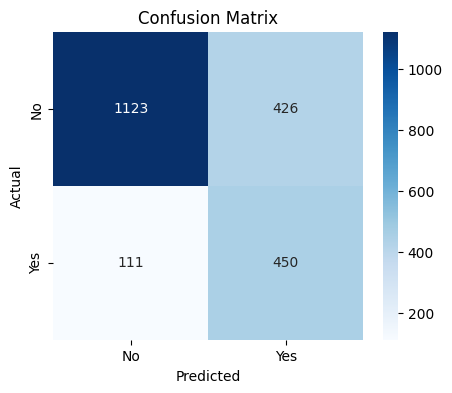

In [90]:
# Создаем тепловую карту
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,  # Подписи для оси X
            yticklabels=best_model.classes_)  # Подписи для оси Y

# Добавляем заголовки для осей
plt.ylabel('Actual')  # Подпись для оси Y
plt.xlabel('Predicted')  # Подпись для оси X

# Отображаем график
plt.title('Confusion Matrix')
plt.show()

In [58]:
# Предыдущая лучшая модель по recall
# {'depth': 4, 'iterations': 150, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
# Validation recall_score: 0.7540106951871658

### XGBoost + Optuna

In [66]:
X_train_resampled_encoded = pd.get_dummies(X_train_resampled, columns=categorical, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical, drop_first=False)

y_train_resampled_encoded = y_train_resampled.map({'Yes': 1, 'No': 0})
y_test_encoded = y_test.map({'Yes': 1, 'No': 0})


In [79]:
from sklearn.model_selection import StratifiedKFold

def objective(trial):

    num_boost_round = trial.suggest_int("num_boost_round", 500, 5000, step=250)
    threshold = trial.suggest_float('threshold', 0.3, 0.7, step=0.1)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': 1.0,
        'seed': 94
    }

    # Кросс-валидация
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=94)
    recall_scores = []

    for train_idx, val_idx in kf.split(X_train_resampled_encoded, y_train_resampled_encoded):
        X_train_fold, X_val_fold = X_train_resampled_encoded.iloc[train_idx, :], X_train_resampled_encoded.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train_resampled_encoded.iloc[train_idx], y_train_resampled_encoded.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        model = xgb.train(params, dtrain, num_boost_round=num_boost_round)
        preds_prob = model.predict(dval)
        preds = (preds_prob >= threshold).astype(int)  # Преобразование вероятностей в классы
        recall_scores.append(recall_score(y_val_fold, preds))

    return np.mean(recall_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=None)

In [83]:
study.best_params

{'num_boost_round': 750,
 'threshold': 0.3,
 'eta': 0.04113387547642672,
 'max_depth': 4,
 'subsample': 0.9120100856951627,
 'colsample_bytree': 0.925233098344705,
 'lambda': 0.004465351440305272,
 'alpha': 0.0021121851300112,
 'min_child_weight': 6}

Recall: 0.7647058823529411
Precision: 0.48584371460928655
Accuracy: 0.7222748815165877
Confusion Matrix:
 [[1095  454]
 [ 132  429]]


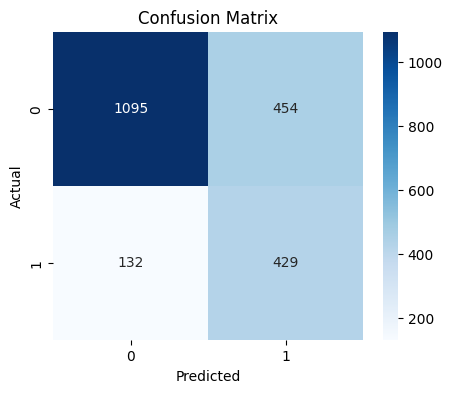

In [91]:

def train_and_evaluate_xgboost(X_train, y_train, X_val, y_val):
    # Определение параметров модели
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.04113387547642672,
        'max_depth': 4,
        'subsample': 0.9120100856951627,
        'colsample_bytree': 0.925233098344705,
        'lambda': 0.004465351440305272,
        'alpha': 0.0021121851300112,
        'min_child_weight': 6,
        'seed': 42
    }
    num_boost_round = 750

    # Создание DMatrix для XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Обучение модели
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # Предсказания на валидационной выборке
    preds_prob = model.predict(dval)
    threshold = 0.35
    preds = (preds_prob >= threshold).astype(int)  # Преобразование вероятностей в классы

    # Вычисление метрик
    recall = recall_score(y_val, preds)
    precision = precision_score(y_val, preds)
    accuracy = accuracy_score(y_val, preds)
    conf_matrix = confusion_matrix(y_val, preds)

    # Вывод метрик
    print("Recall:", recall)
    print("Precision:", precision)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)

        # Создаем тепловую карту
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')  # Подписи для оси Y

    # Добавляем заголовки для осей
    plt.ylabel('Actual')  # Подпись для оси Y
    plt.xlabel('Predicted')  # Подпись для оси X

    # Отображаем график
    plt.title('Confusion Matrix')
    plt.show()

    return model

# Пример вызова функции
model = train_and_evaluate_xgboost(
    X_train_resampled_encoded, 
    y_train_resampled_encoded, 
    X_test_encoded, 
    y_test_encoded
)

### SHAP + Catboost

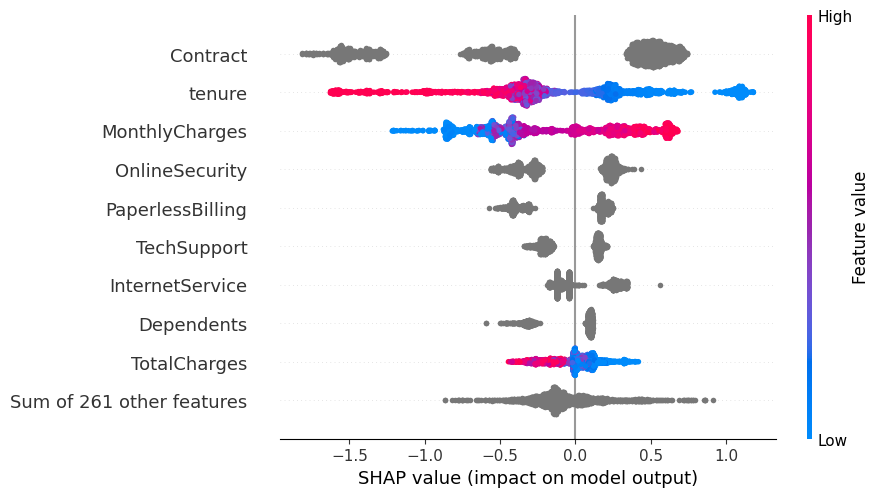

In [86]:
# Создание объясняющего объекта SHAP для CatBoost
explainer = shap.TreeExplainer(best_model)

# Вычисление SHAP-значений
shap_values = explainer.shap_values(X_test)

# # Визуализация SHAP-значений
# shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=10)

# Альтернативная визуализация: beeswarm plot
shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test.values,
    feature_names=X_test.columns.tolist()
), max_display=10)